# Identifying Negative Sentiment in Tweets

## Business Problem

Google is seeking to increase Android's share of the U.S. smartphone and tablet markets.  To do so, they are seeking information on what consumers don't like about their devices.  By focusing on pain points, they hope to engineer improvements that will attract and retain more customers.

While negative sentiment toward products is available in form of survey responses and customer complaints, Google also hopes to access the opinions conveyed in social media posts.  To do so, they need to identify posts which express concerns and frustrations about mobile devices from among thousands of other posts.  Google is frustrated that their analysts spend so much time reading through positive and neutral posts to find the negative ones, which comprise just 6% of all posts.

My task is to build a natural language processing model which can identify the negative tweets.  They have asked that the model focus on catching as many negative tweets as possible, but would like analysts to be able to work at least twice as fast.  So, the model should eliminate enough positive and neutral posts that negative tweets comprise at least 12% of all the tweets returned.

## Data Understanding

To identify posts with gripes, I analyzed over 9,000 tweets from a dataset provided by Crowdflower via [data.world](https://data.world/crowdflower/brands-and-product-emotions).  The tweets all contain references to Google or Apple products by participants in the South by Southwest (SXSW) Conference in 2011.  Although the data are a decade old, and the products discussed seem ancient (e.g. iPad 2), the words used to convey negative emotions have not changed.  

Each tweet in the dataset has been rated by humans as showing a positive emotion, negative emotion, or no emotion toward the Google or Apple product mentioned.  59% of tweets were tagged as postive and 6% as negative, making negative tweets the smallest category by far.  I combined the positive and no-emotion categories in order to build a binary classification model that can identify negative tweets.

## Data Preparation

The data contained just one null value in the tweet text, which I dropped.

To prepare the data for modeling, I combined the positive and no-emotion categories in order to build a binary classification model that can identify negative tweets.

I also set aside 10% of the data as a holdout set, which I later used to validate the final model.

In [360]:
# import code libraries

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_colwidth', 1000)
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.naive_bayes import ComplementNB, MultinomialNB

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

import utils as ut

In [361]:
# import data

data = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding='latin-1')


In [362]:
data.head(200)


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy And Communication Are Showcased At The #SXSW Conference http://ht.ly/49n4M #iear #edchat #asd,NaN,No emotion toward brand or product
6,NaN,NaN,No emotion toward brand or product
7,"#SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan",Android,Positive emotion
8,Beautifully smart and simple idea RT @madebymany @thenextweb wrote about our #hollergram iPad app for #sxsw! http://bit.ly/ieaVOB,iPad or iPhone App,Positive emotion
9,Counting down the days to #sxsw plus strong Canadian dollar means stock up on Apple gear,Apple,Positive emotion


In [363]:
# check data length

len(data)

9093

In [364]:
# change column names to 'text' and 'label'

data.rename(columns={'tweet_text':'text', 'is_there_an_emotion_directed_at_a_brand_or_product': 'label'}, inplace=True)

In [365]:
# drop product column since this model will only predict sentiment, not the product as well

data.drop(columns = 'emotion_in_tweet_is_directed_at', inplace=True)

In [366]:
# data has one null value in the text

data.isna().sum()

text     1
label    0
dtype: int64

In [367]:
# drop null value

data.dropna(inplace=True)

In [368]:
# recheck data length

len(data)

9092

In [369]:
# reset index after dropping null value so train/test splits work later on

data.reset_index(drop=True, inplace=True)

In [370]:
# check label distribution

data['label'].value_counts(normalize=True)

No emotion toward brand or product   0.59261
Positive emotion                     0.32754
Negative emotion                     0.06269
I can't tell                         0.01716
Name: label, dtype: float64

In [371]:
# create temporary df to plot label distribution

df_plot = pd.DataFrame(data['label'].value_counts(normalize=True)).reset_index()
df_plot.rename(columns={'label': 'Per Cent of Tweets', 'index': 'Sentiment'}, inplace=True)
df_plot['Sentiment'] = df_plot['Sentiment'].map(lambda x: 'No emotion' if x == 'No emotion toward brand or product'
                                               else x)

In [372]:
df_plot

,Sentiment,Per Cent of Tweets
0,No emotion,0.59261
1,Positive emotion,0.32754
2,Negative emotion,0.06269
3,I can't tell,0.01716


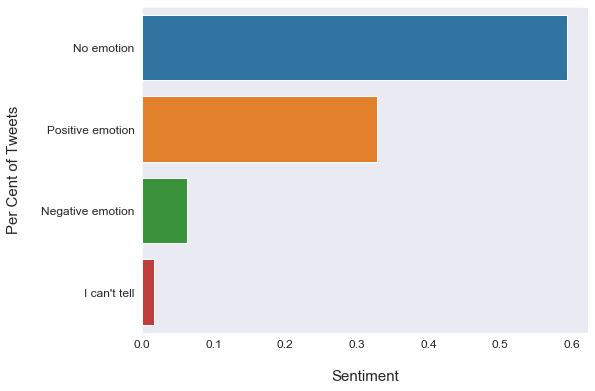

In [373]:
# plot original label distribution

fig = plt.figure(figsize=(8,6))
sns.set_style('dark')
sns.barplot(x='Per Cent of Tweets', y='Sentiment', data=df_plot, orient='h')
plt.xlabel('Sentiment', fontsize=15, labelpad=20)
plt.ylabel('Per Cent of Tweets', fontsize=15, labelpad=20)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12);



In [374]:
# combine "No emotion toward brand or product", "I can't tell", and "Positive emotion"
# since the goal is to find negative tweets

data['label'] = data['label'].map(lambda x: 'Not negative' if x != "Negative emotion"
                                 else x)

In [375]:
# check out new label distribution

data['label'].value_counts(normalize=True)

Not negative       0.93731
Negative emotion   0.06269
Name: label, dtype: float64

In [376]:
# create temporary df to plot new label distribution

df_plot_2 = pd.DataFrame(data['label'].value_counts(normalize=True)).reset_index()
df_plot_2.rename(columns={'label': 'Per Cent of Tweets', 'index': 'Sentiment'}, inplace=True)
df_plot_2['Sentiment'] = df_plot_2['Sentiment'].map(lambda x: 'No emotion' if x == 'No emotion toward brand or product'
                                               else x)

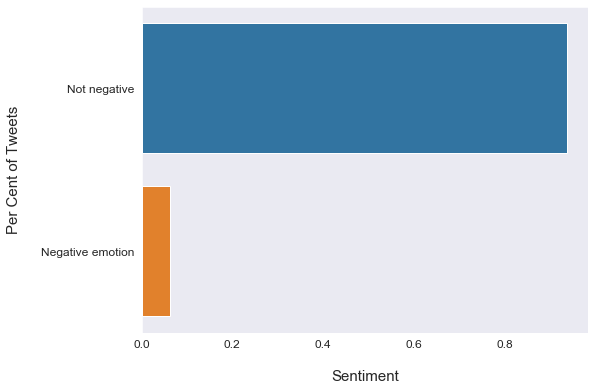

In [377]:
# plot new label distribution

fig = plt.figure(figsize=(8,6))
sns.set_style('dark')
sns.barplot(x='Per Cent of Tweets', y='Sentiment', data=df_plot_2, orient='h')
plt.xlabel('Sentiment', fontsize=15, labelpad=20)
plt.ylabel('Per Cent of Tweets', fontsize=15, labelpad=20)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12);

In [378]:
# create X and y

X = data['text']
y = data['label']


In [379]:
# reformat X to lowercase and string (some tweets were numeric)

X = X.astype(str).map(lambda x: x.lower())


In [380]:
# create holdout set as 10% of data.  Set aside until final model validation

X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.07)

print(len(X_train), len(X_holdout))


8455 637


In [381]:
# cast X_train as string to make sure no values are numeric

X_train = X_train.astype(str).map(lambda x: x.lower())


## Modeling

### Model Evaluation

To evaluate all models tested, I used their recall and precision scores.  The recall score shows what per cent of true negative-sentiment tweets were captured by each model.  The precision score shows what per cent of the tweets returned by the model are actually negative-sentiment.  In order for Google to reduce their analysts' workload by half, the tweets returned need to be at least 12% negative-sentiment, since 6% of all tweets are negative-sentiment.
I cross-validated the scores by testing each model using five different train/test splits of the data, and then taking the mean scores.

### Model 1: Baseline Model

The first model I tested used ScikitLearn's CountVectorizer to turn each tweet into a numerical vector by counting how many times each word appeared in the tweet.  For this initial model, I included only single words and not n-grams in the vectorizer, and I did not set a maximum limit on the number of features.
I then fed the vectorized tweets into ScikitLearn's Multinomial Naive Bayes classifier.  This classifier supports binary as well as multi-class problems with discrete features, such as text classification.

The baseline model's mean **recall score was 0.11** for the test data, and its **precision score was 0.45**, as shown below.  While this model would significantly speed up analysts' work as almost half of all tweets returned are truly negative-sentiment, it would not be useful to Google because about 90% of negative-sentiment tweets would be missed.

In [382]:
# create count vectorizer for testing

countvec = CountVectorizer()

In [383]:
# create Multinomial Naive Bayes model for testing

nb_count = MultinomialNB()

Vectorizer: CountVectorizer()
Classifier: MultinomialNB()
Cross-validation folds: 5
Train mean recall: 0.4 +/- 0.02
Train mean precision: 0.72 +/- 0.01
Train mean F1: 0.51 +/- 0.02
Test mean recall: 0.13 +/- 0.01
Test mean precision: 0.54 +/- 0.08
Test mean F1: 0.21 +/- 0.02


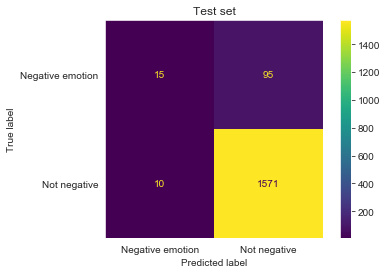

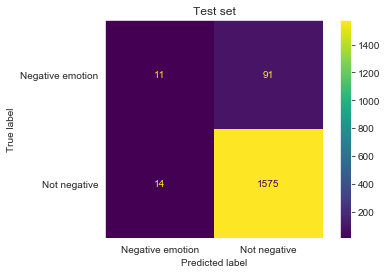

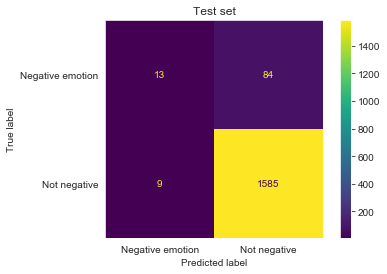

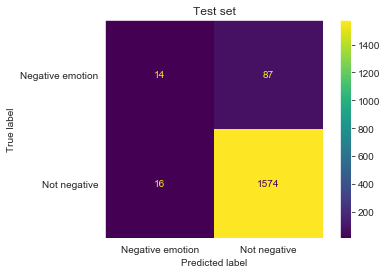

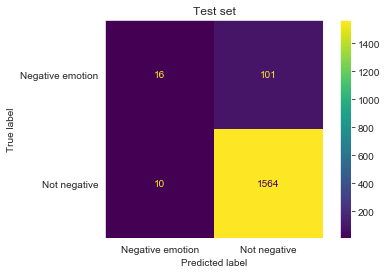

In [384]:
# test baseline model with basic countvectorizer and Multinomial Bayes model

ut.k_fold_validator(X_train, y_train, vectorizer=countvec, classifier=nb_count, cv=5)


### Model 2: TF-IDF Model

Next, I tested using a Term Frequency/Inverse Document Frequency vectorizer instead of the count vectorizer.  This model produced even worse results, with a **mean recall and precision scores of 0**, meaning the model did not predict any tweets were negative-sentiment.  One problem with using a TF-IDF vectorizer for tweets is that it downscales words that appear often in many documents to highlight words that truly typify one document.  Tweets are so short that there are probably few words that appear multiple times in any one tweet.  

In [385]:
# create TF-IDF vectoriser for testing

tfidfvec = TfidfVectorizer()

Vectorizer: TfidfVectorizer()
Classifier: MultinomialNB()
Cross-validation folds: 5


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train mean recall: 0.01 +/- 0.01
Train mean precision: 0.83 +/- 0.13
Train mean F1: 0.02 +/- 0.01
Test mean recall: 0.0 +/- 0.0
Test mean precision: 0.2 +/- 0.45
Test mean F1: 0.0 +/- 0.01


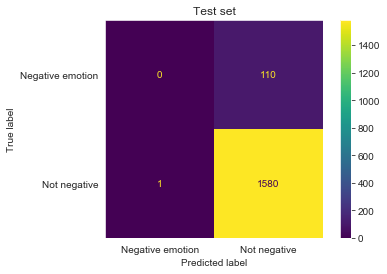

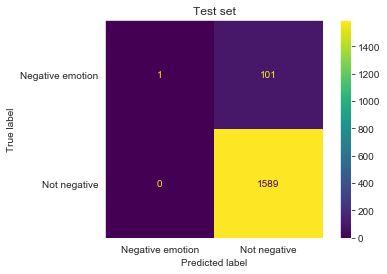

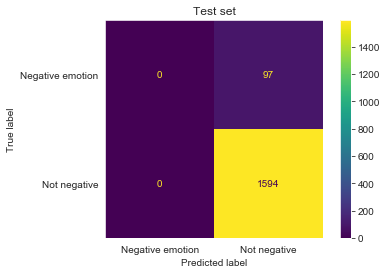

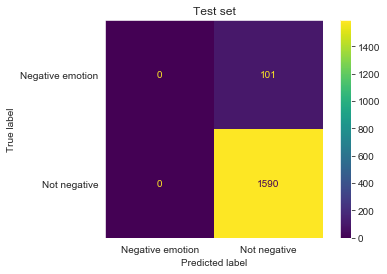

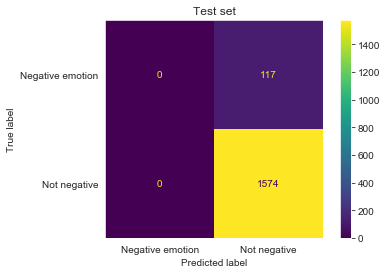

In [386]:
ut.k_fold_validator(predictor=X_train, target=y_train, vectorizer=tfidfvec, classifier=nb_count, cv=5)

### Model 3: Complement Naive Bayes Model

This model used a count vectorizer with a ScikitLearn's Complement Naive Bayes classifier.  This classifier is designed to remedy class imbalance problems.  This model **improved recall to 0.23** but at the cost of **precision which fell to 0.34**.  Since 0.34 is still above the 12% threshold set by Google, we will stick with this model to catch more negative-sentiment tweets.

In [412]:
compnb = ComplementNB()

Vectorizer: CountVectorizer()
Classifier: ComplementNB()
Cross-validation folds: 5
Train mean recall: 0.58 +/- 0.02
Train mean precision: 0.52 +/- 0.01
Train mean F1: 0.55 +/- 0.02
Test mean recall: 0.23 +/- 0.02
Test mean precision: 0.34 +/- 0.04
Test mean F1: 0.27 +/- 0.02


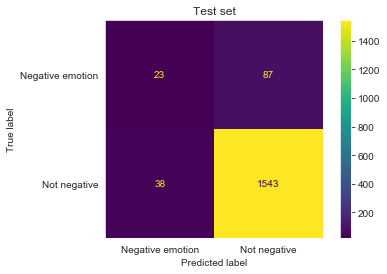

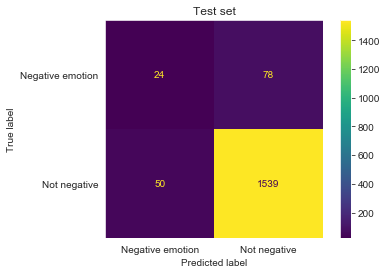

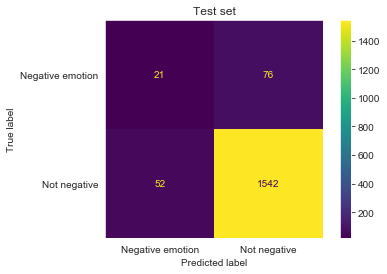

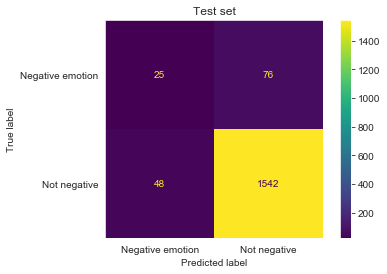

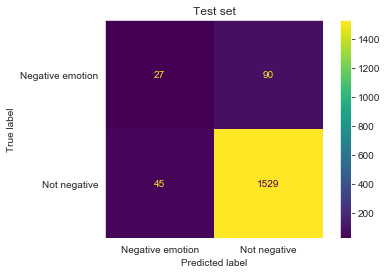

In [411]:
ut.k_fold_validator(predictor=X_train, target=y_train, vectorizer=countvec, classifier=compnb, cv=5)

### Model 4: Count Vectorizer with Stop Words

This model used a count vectorizer that contained a list of stop words - words to exclude from the vectorized data's features.  This list included common English stopwords from Natural Language Toolkit, and punctuation.  The model also used a Complement Naive Bayes classifier.

Including these stopwords improved **recall to 0.33**, while **precision fell to 0.34**.

In [413]:
# create stopwords list for testing

stopwords_list = stopwords.words('english')
stopwords_list += string.punctuation
stopwords_list += ['sxsw','mention','rt']

In [414]:
stopwords_list

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [415]:
# create new count vectorizer that includes stopwords

cv_stop = CountVectorizer(stop_words=stopwords_list)

Vectorizer: CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])
Classifier: ComplementNB()
Cross-validation folds: 5
Train mean recall: 0.71 +/- 0.01
Train mean precision: 0.42 +/- 0.01
Train mean F1: 0.53 +/- 0.01
Test mean recall: 0.33 +/- 0.01
Test mean precision: 0.27 +/- 0.04
Test mean F1: 0.3 +/- 0.02


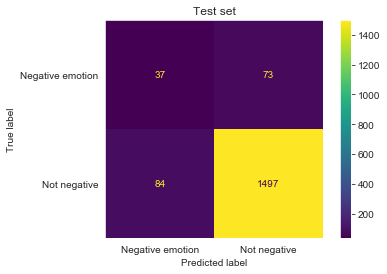

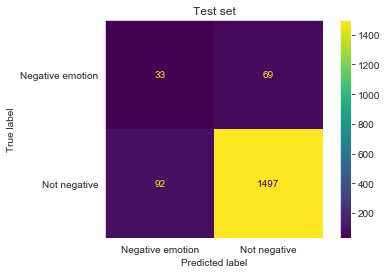

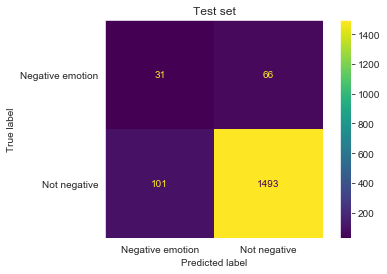

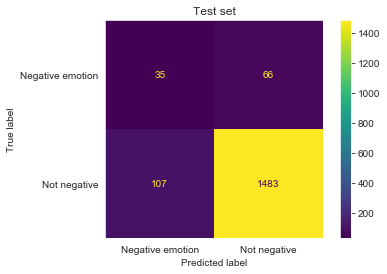

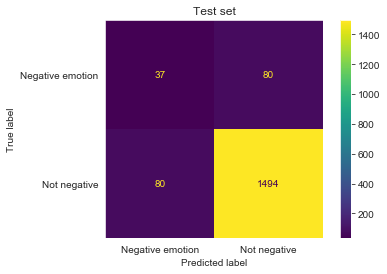

In [420]:
# test model 3

ut.k_fold_validator(predictor=X_train, target=y_train, vectorizer=cv_stop, classifier=compnb, cv=5)

### Model 5: Count Vectorizer with Short Stopwords List

I tested a model with a very short stopwords list, thinking that tweets are so short we may be getting good information from the small words and punctuation that had been excluded.  However, this stopwords list did not improve model performance, as **recall fell significantly to 0.24.  Precision climbed to 0.31** but at the cost of missed negative-sentiment tweets.  Excluding the small words and punctuation from the vectorized data was useful.

In [391]:
# create alternative stopwords list for testing
# since tweets are so short, we may be getting good info from punctuation and small words

stopwords_list_2 = ['sxsw', 'mention', 'rt']

In [392]:
cv_stop_2 = CountVectorizer(stop_words=stopwords_list_2)

Vectorizer: CountVectorizer(stop_words=['sxsw', 'mention', 'rt'])
Classifier: ComplementNB()
Cross-validation folds: 5
Train mean recall: 0.61 +/- 0.02
Train mean precision: 0.5 +/- 0.01
Train mean F1: 0.55 +/- 0.02
Test mean recall: 0.24 +/- 0.03
Test mean precision: 0.31 +/- 0.05
Test mean F1: 0.27 +/- 0.03


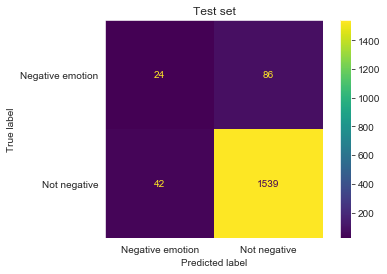

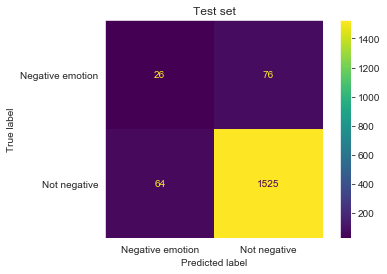

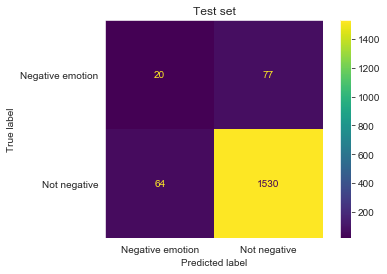

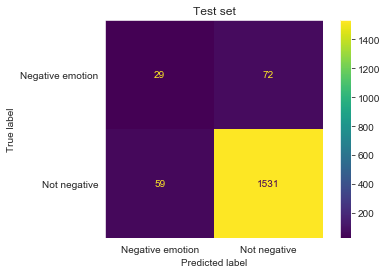

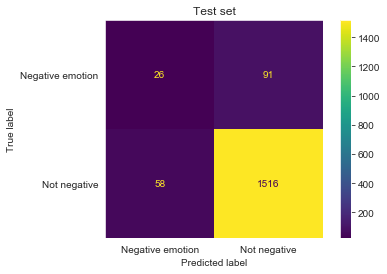

In [421]:
ut.k_fold_validator(predictor=X_train, target=y_train, vectorizer=cv_stop_2, classifier=compnb, cv=5)

### Model 6: Count Vectorizer with Stop Words and Max Features

This model set the maximum number of features to include in the vectorized data at 3,000.  Doing so significantly improved **recall to 0.58** and reduced **precision to 0.19**, still above the threshold of 12%.

In [432]:
cv_stop_max = CountVectorizer(stop_words=stopwords_list, max_features=3000)

Vectorizer: CountVectorizer(max_features=3000,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])
Classifier: ComplementNB()
Cross-validation folds: 5
Train mean recall: 0.82 +/- 0.01
Train mean precision: 0.25 +/- 0.01
Train mean F1: 0.38 +/- 0.01
Test mean recall: 0.58 +/- 0.02
Test mean precision: 0.19 +/- 0.02
Test mean F1: 0.28 +/- 0.02


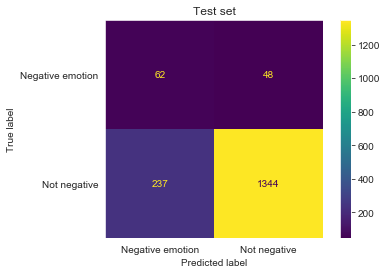

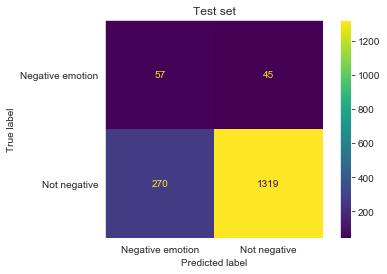

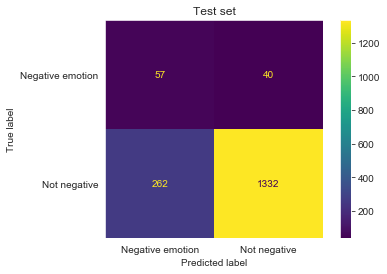

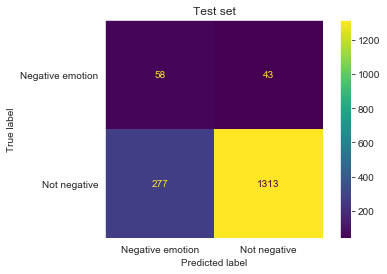

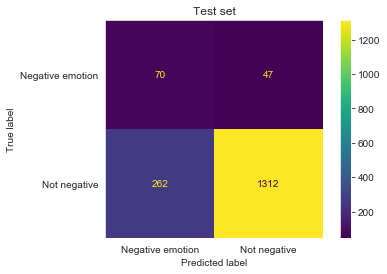

In [436]:
ut.k_fold_validator(predictor=X_train, target=y_train, vectorizer=cv_stop_max, classifier=compnb, cv=5)

### Model 7: Count Vectorizer with Stop Words, Max Features, and N-grams

This model set an n-gram length of 3, so single words as two- and three-word blocks could all be included as features.  The model retained the stop words list and maximum feature limit used previously.  **Recall jumped again to 0.65** while **precision fell only slightly to 0.16**.

In [437]:
cv_stop_max_ngram = CountVectorizer(stop_words=stopwords_list, max_features=3000, ngram_range=(1, 3))

Vectorizer: CountVectorizer(max_features=3000, ngram_range=(1, 3),
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])
Classifier: ComplementNB()
Cross-validation folds: 5
Train mean recall: 0.85 +/- 0.0
Train mean precision: 0.2 +/- 0.01
Train mean F1: 0.32 +/- 0.01
Test mean recall: 0.65 +/- 0.02
Test mean precision: 0.16 +/- 0.02
Test mean F1: 0.26 +/- 0.02


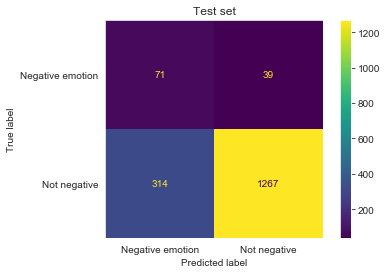

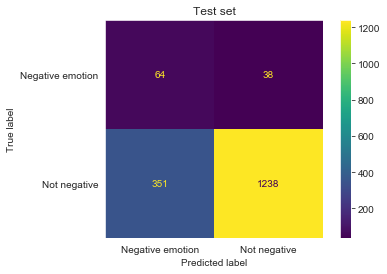

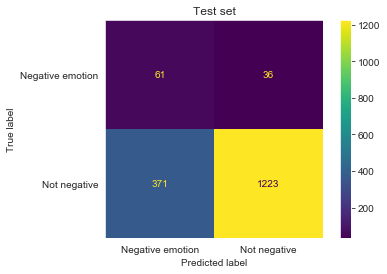

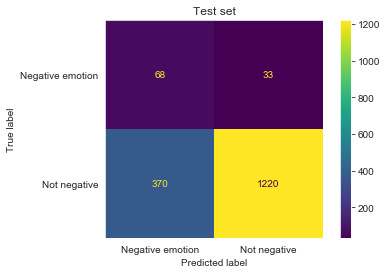

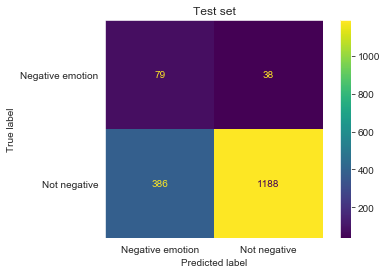

In [438]:
ut.k_fold_validator(predictor=X_train, target=y_train, vectorizer=cv_stop_max_ngram, classifier=compnb, cv=5)

### Model 8: Count Vectorizer with Stop Words, N-grams, and no Max Features

This model is identical to Model 7, but does not set a maximum feature limit.  I was curious to see the affect of n-grams without the feature limit.  This model had a **recall score of only 0.24** and **a precision score of 0.5**.  N-grams only improve recall when a maximum feature limit is set.

In [447]:
# create count vectorizer with stopwords list and ngrams but no max features limit

cv_stop_ngram = CountVectorizer(stop_words=stopwords_list, ngram_range=(1, 3))

Vectorizer: CountVectorizer(ngram_range=(1, 3),
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])
Classifier: ComplementNB()
Cross-validation folds: 5
Train mean recall: 0.9 +/- 0.0
Train mean precision: 0.68 +/- 0.01
Train mean F1: 0.78 +/- 0.01
Test mean recall: 0.24 +/- 0.02
Test mean precision: 0.5 +/- 0.04
Test mean F1: 0.33 +/- 0.02


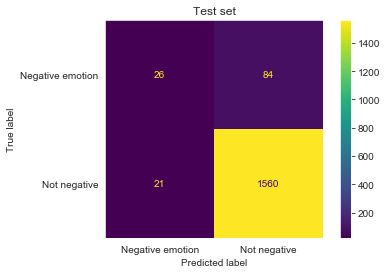

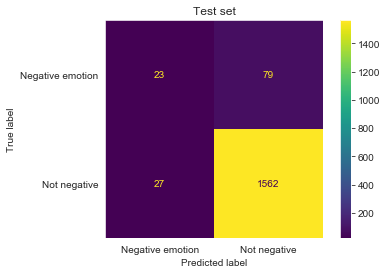

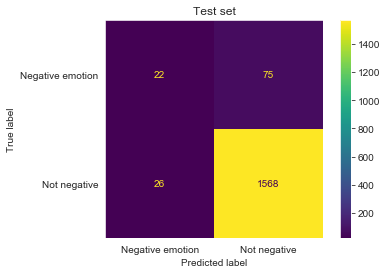

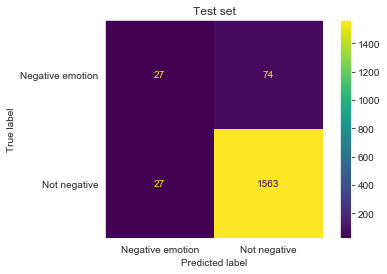

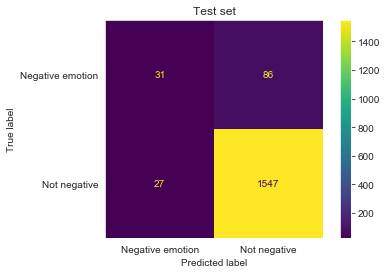

In [448]:
# ngrams don't improve recall without max

ut.k_fold_validator(predictor=X_train, target=y_train, vectorizer=cv_stop_ngram, classifier=compnb, cv=5)

### Model 9: Iterate on max features and n-gram length

This model attempts to improve on Model 7 by testing max features set at 2000 and 4000, and n-gram max lengths set at 2 and 4.  After iterating through these combinations, max features at 2000 and n-gram range between 1 and 3 performed best.  Max features set at 1500 performed even better.

In [478]:
cv_stop_max_ngram_2 = CountVectorizer(stop_words=stopwords_list, max_features=1500, ngram_range=(1, 3))

Vectorizer: CountVectorizer(max_features=1500, ngram_range=(1, 3),
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])
Classifier: ComplementNB()
Cross-validation folds: 5
Train mean recall: 0.85 +/- 0.01
Train mean precision: 0.17 +/- 0.01
Train mean F1: 0.28 +/- 0.01
Test mean recall: 0.72 +/- 0.05
Test mean precision: 0.14 +/- 0.02
Test mean F1: 0.23 +/- 0.03


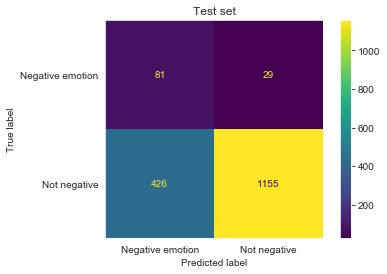

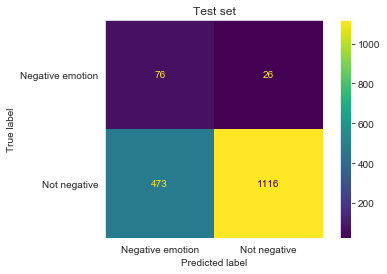

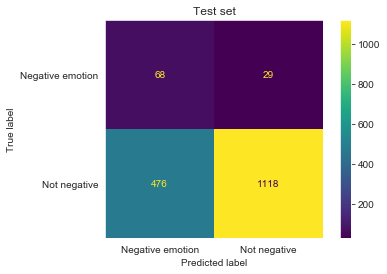

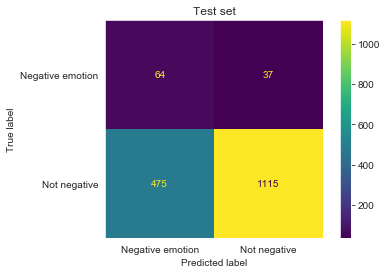

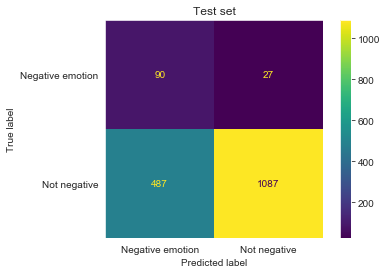

In [479]:
# max 2k is a little better than 3k and 1k, 1500 is best
# ngram range 3 is better than 2 and 4
ut.k_fold_validator(predictor=X_train, target=y_train, vectorizer=cv_stop_max_ngram_2, classifier=compnb, cv=5)

In [482]:
cv_stop_max_ngram_3 = CountVectorizer(stop_words=stopwords_list_2, max_features=1500, ngram_range=(1, 3))

Vectorizer: CountVectorizer(max_features=1500, ngram_range=(1, 3),
                stop_words=['sxsw', 'mention', 'rt'])
Classifier: ComplementNB()
Cross-validation folds: 5
Train mean recall: 0.89 +/- 0.01
Train mean precision: 0.16 +/- 0.01
Train mean F1: 0.27 +/- 0.01
Test mean recall: 0.78 +/- 0.03
Test mean precision: 0.14 +/- 0.02
Test mean F1: 0.24 +/- 0.02


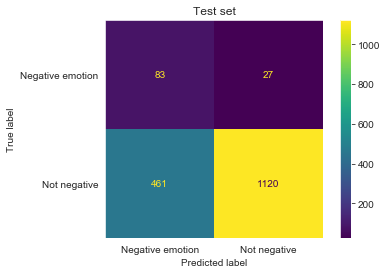

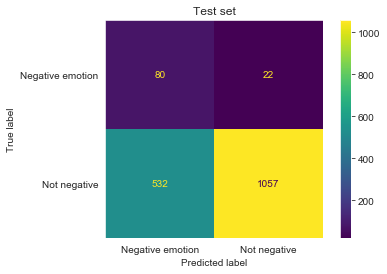

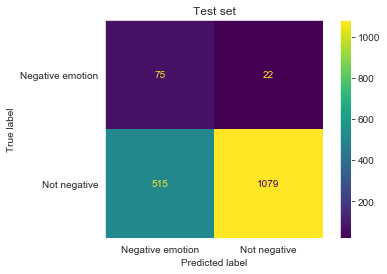

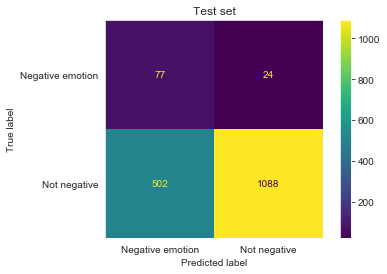

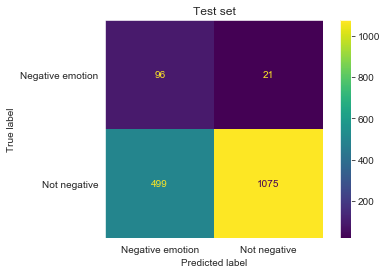

In [483]:

ut.k_fold_validator(predictor=X_train, target=y_train, vectorizer=cv_stop_max_ngram_3, classifier=compnb, cv=5)

Train recall score: 0.89
Train precision score: 0.16
Train F1 score: 0.27


Holdout recall score: 0.84
Holdout precision score: 0.17
Holdout F1 score: 0.28


Text(0.5, 1.0, 'Holdout set')

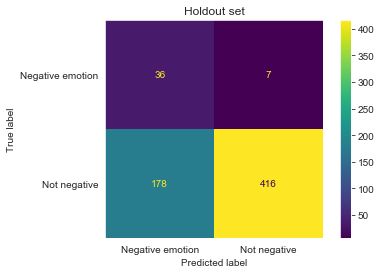

In [477]:
# test final model on holdout set

X_vec_train = cv_stop_max_ngram_2.fit_transform(X_train)
X_vec_holdout = cv_stop_max_ngram_2.transform(X_holdout)

clf = compnb
clf.fit(X_vec_train, y_train)

y_pred_train = clf.predict(X_vec_train)
y_pred_holdout = clf.predict(X_vec_holdout)

print('Train recall score:', round(recall_score(y_train, y_pred_train, pos_label='Negative emotion'), 2))
print('Train precision score:', round(precision_score(y_train, y_pred_train, pos_label='Negative emotion'), 2))
print('Train F1 score:', round(f1_score(y_train, y_pred_train, pos_label='Negative emotion'), 2))       
print('\n')
print('Holdout recall score:', round(recall_score(y_holdout, y_pred_holdout, pos_label='Negative emotion'), 2))
print('Holdout precision score:', round(precision_score(y_holdout, y_pred_holdout, pos_label='Negative emotion'), 2))
print('Holdout F1 score:', round(f1_score(y_holdout, y_pred_holdout, pos_label='Negative emotion'), 2))       

plot_confusion_matrix(clf, X_vec_holdout, y_holdout)
plt.title('Holdout set')

In [406]:
# with precision of 15%, you need to read through
100/15
# 7 tweets to find a negative one
# 22% of negative tweets are missed

6.666666666666667

In [407]:
# you have to read through 17 tweets to find a negative one
100/6.2

16.129032258064516

In [408]:
# you get through your work 2 or 3 times as fast